# Homework 2 - Generalized Hough Transform

## Theory

### Task 1
Answer: iv <br>
Counter-clockwise rotation of 90: (x, y) -&gt; (-y, x)

### Task 2
Answer: iii <br>
symmetric

## Programming

Find object in an image using a template:  
![title](data/template.jpg)
![title](data/query.jpg)

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import cv2
import utils
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

def nonMaxSuprression(img, d=5):
    """
    Given an image set all values to 0 that are not
    the maximum in its (2d+1,2d+1)-window

    Parameters
    ----------
    img : ndarray
        an image
    d : int
        for each pixels consider the surrounding (2d+1,2d+1)-window  

    Returns
    -------
    result : ndarray

    """
    rows, cols = img.shape
    result = np.zeros((rows, cols))
    
    for i in range(d, rows - d):
        for j in range(d, cols - d):
            local_patch = img[i-d:i+d+1, j-d:j+d+1]
            local_max = np.max(local_patch)
            if img[i, j] == local_max:
                result[i, j] = img[i, j]
            
    return result

def calcBinaryMask(img, thresh = 0.3):
    """
    Compute the gradient of an image and compute a binary mask
    based on the threshold. Corresponds to O^B in the slides.

    Parameters
    ----------
    img : ndarray
        an image
    thresh : float
        A threshold value. The default is 0.3.

    Returns
    -------
    binary : ndarray
        A binary image.

    """

    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    _, binary = cv2.threshold(magnitude, thresh * np.max(magnitude), 255, cv2.THRESH_BINARY)
    binary = binary.astype(np.uint8)
    return binary

def correlation(img, template):
    """
    Compute a correlation of gradients between an image and a template.
    
    Note:
    You should use the formula in the slides using the fourier transform.
    Then you are guaranteed to succeed.
    
    However, you can also compute the correlation directly. 
    The resulting image must have high positive values at positions
    with high correlation.

    Parameters
    ----------
    img : ndarray
        a grayscale image
    template : ndarray
        a grayscale image of the template

    Returns
    -------
    ndarray
        an image containing the correlation between image and template gradients.
    """
    
    img_fft = np.fft.fft2(img)
    template_fft = np.fft.fft2(template, s=img.shape)
    template_fft_conj = np.conj(template_fft)
    
    correlation = np.fft.ifft2(img_fft * template_fft_conj)
    correlation = np.fft.fftshift(correlation)
    correlation = np.abs(correlation)
    
    return correlation

def GeneralizedHoughTransform(img, template, angles, scales):
    """
    Compute the generalized hough transform. Given an image and a template.
    
    Parameters
    ----------
    img : ndarray
        A query image
    template : ndarray
        a template image
    angles : list[float]
        A list of angles provided in degrees
    scales : list[float]
        A list of scaling factors

    Returns
    -------
    hough_table : list[(correlation, angle, scaling)]
        The resulting hough table is a list of tuples.
        Each tuple contains the correlation and the corresponding combination
        of angle and scaling factors of the template.
        
        Note the order of these values.
    """
    height, width = query.shape
    accumulator = np.zeros((len(angles), len(scales), height, width))
    
    binary_template = calcBinaryMask(template)
    template_edges = np.argwhere(binary_template > 0)
    template_center = np.mean(template_edges, axis=0).astype(float)
    
    grad_x_template = cv2.Sobel(template, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_template = cv2.Sobel(template, cv2.CV_64F, 0, 1, ksize=3)
    angle_template = np.arctan2(grad_y_template, grad_x_template)
    
    for i, angle in enumerate(angles):
        for j, scale in enumerate(scales):
            rotation_matrix = cv2.getRotationMatrix2D((template_center[1], template_center[0]), angle, scale)
            rotated_template = cv2.warpAffine(template, rotation_matrix, (width, height))
            rotated_binary_template = calcBinaryMask(rotated_template)
            
            grad_x_rotated = cv2.Sobel(rotated_template, cv2.CV_64F, 1, 0, ksize=3)
            grad_y_rotated = cv2.Sobel(rotated_template, cv2.CV_64F, 0, 1, ksize=3)
            angle_rotated = np.arctan2(grad_y_rotated, grad_x_rotated)
            
            correlation_result = correlation(query, rotated_binary_template)
            accumulator[i, j] = correlation_result
    
    max_indices = np.unravel_index(np.argmax(accumulator, axis=None), accumulator.shape)
    thetas = angles[max_indices[0]]
    scales = scales[max_indices[1]]
    votes = accumulator[max_indices[0], max_indices[1]]
    hough_table=[]
    hough_table.append((votes, thetas, scales))
    
    return hough_table

# Main Program

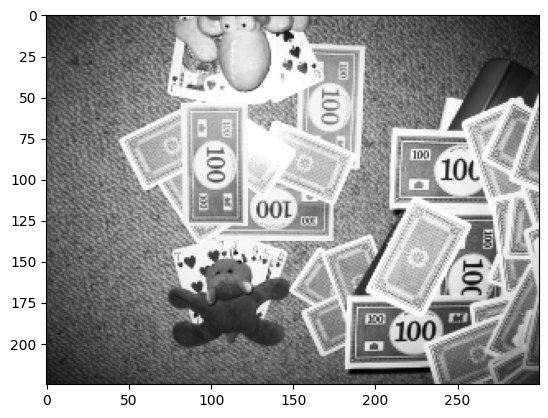

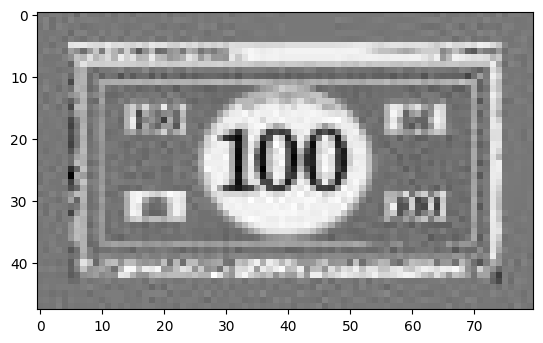

Hough votes


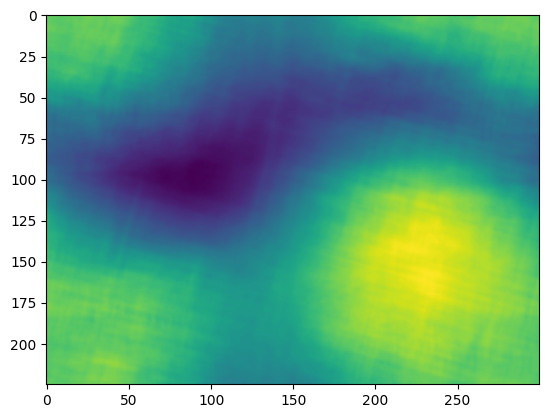

Filtered Hough votes


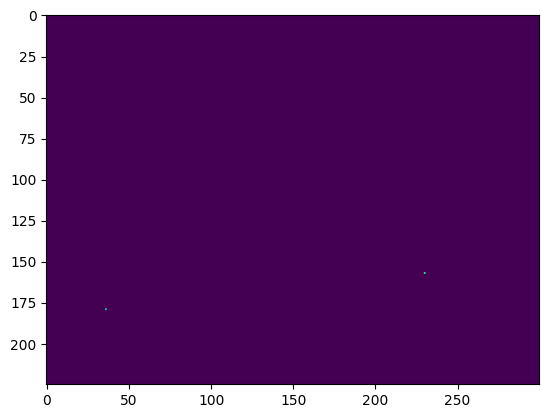

Detected Positions
293 74
294 74
299 74
298 74
297 74
296 74
295 74
36 179
230 157
299 224


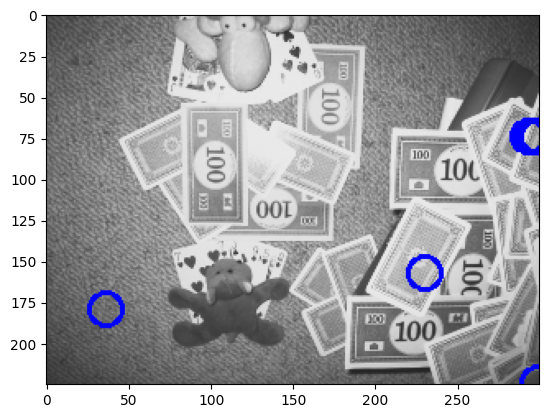

In [13]:
# Load query image and template 
query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)

# Visualize images
utils.show(query)
utils.show(template)

# Create search space and compute GHT
angles = np.linspace(0, 360, 36)
scales = np.linspace(0.9, 1.3, 10)
ght = GeneralizedHoughTransform(query, template, angles, scales)

# extract votes (correlation) and parameters
votes, thetas, s = zip(*ght)

# Visualize votes
print("Hough votes")
votes = np.stack(votes).max(0)
plt.imshow(votes)
plt.show()

# nonMaxSuprression
print("Filtered Hough votes")
votes = nonMaxSuprression(votes, 20)
plt.imshow(votes)
plt.show()

# Visualize n best matches
n = 10
coords = zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape))
vis = np.stack(3*[query],2)
print("Detected Positions")
for y,x in coords:
    print(x,y)
    vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
utils.show(vis)


# Test your implementation

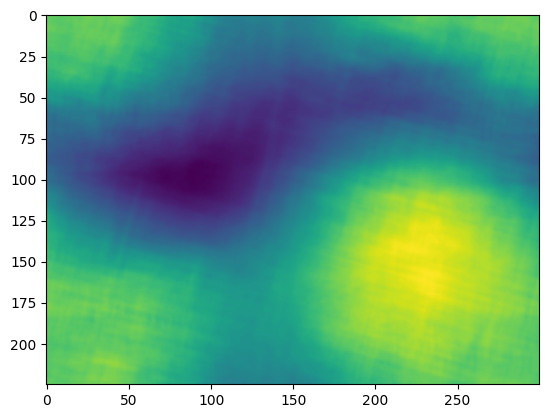

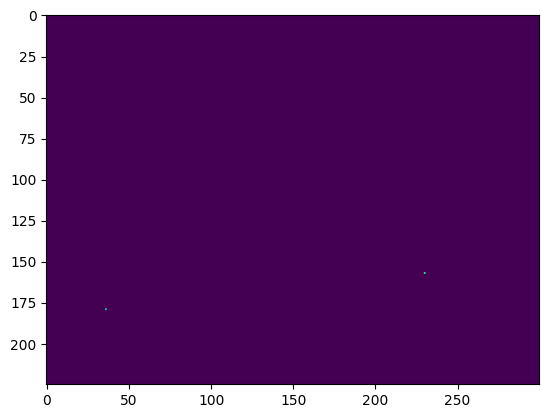

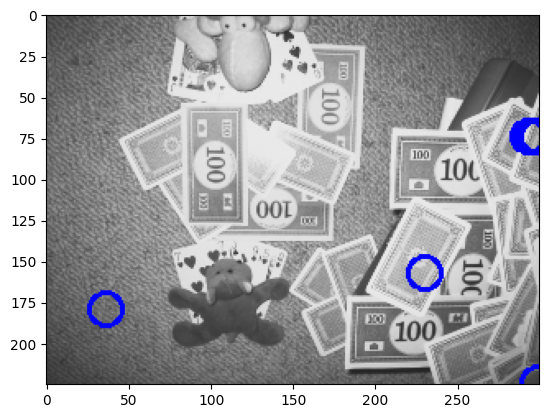

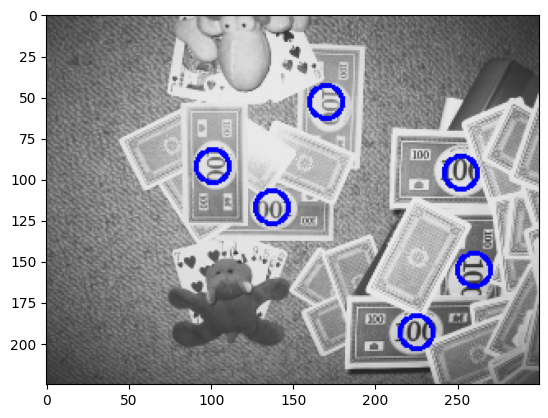

{"scores": {"Correct_Detections": 0}}


In [14]:
import utils
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


def testGHT():
    # Load Images
    query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
    template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)
    
    # GHT with search space
    angles = np.linspace(0, 360, 36)
    scales = np.linspace(0.9, 1.3, 10)
    ght = GeneralizedHoughTransform(query, template, angles, scales)
    
    # Visualize GHT votes
    votes, thetas, s = zip(*ght)
    votes = np.stack(votes).max(0)
    plt.imshow(votes)
    plt.show()

    # Visualize filtered points
    votes = nonMaxSuprression(votes, 20)
    plt.imshow(votes)
    plt.show()

    # Extract n points wiht highest voting score
    n = 10
    coords = list(zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape)))
    vis = np.stack(3*[query],2)
    for y,x in coords:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)

    # Compare with ground-truth centroids
    f = open("centroids.txt", "r")
    centroids = f.read()
    f.close()
    centroids = centroids.split("\n")[:-1]
    centroids = [centroid.split() for centroid in centroids]
    centroids = np.array([[int(centroid[0]),int(centroid[1])] for centroid in centroids])
    
    # Visualize centroids
    vis = np.stack(3*[query],2)
    for x,y in centroids:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)
    
    # Compute Distances and apply threshold
    coords = np.array(coords)[:,::-1]
    d = euclidean_distances(centroids, coords).min(1)
    correct_detections = np.count_nonzero((d<10))
    score = { "scores": {"Correct_Detections": correct_detections }}
    
    print(json.dumps(score))

testGHT()